# ATLAS Integration Challenge

The next cell updates dependencies, make sure to restart the kernel afterwards.

In [33]:
! pip install --upgrade --quiet atlas_schema
! pip install --upgrade --quiet --pre mplhep

  Attempting uninstall: mplhep
    Found existing installation: mplhep 1.0.0rc7.dev11+g271a85873
    Uninstalling mplhep-1.0.0rc7.dev11+g271a85873:
      Successfully uninstalled mplhep-1.0.0rc7.dev11+g271a85873


'1.0.0rc7.dev11+g271a85873'

In [34]:
import collections
import gzip
import json
import math
import pathlib
import time

import awkward as ak
import cloudpickle
import dask
import dask.bag
import hist
import matplotlib.pyplot as plt
import numpy as np
import uproot
import vector

from atlas_schema.schema import NtupleSchema
from coffea import processor
from coffea.nanoevents import NanoEventsFactory
from dask.distributed import Client, PipInstall, performance_report
from IPython.display import display

import utils

vector.register_awkward()
mplhep.style.use(mplhep.style.ATLAS1)

client = Client("tls://localhost:8786")

plugin = PipInstall(packages=["atlas_schema"], pip_options=["--upgrade"])
client.register_plugin(plugin)

cloudpickle.register_pickle_by_value(utils)

### Fileset preparation

Comment out the desired version in the next cell to run over the full input dataset or a subset.

In [ ]:
# full scale
# fileset, input_size_GB = utils.get_fileset(campaign_filter=None, dsid_filter=None, max_files_per_sample=None)

# 9% of full scale, using 2022 data + MC
fileset, input_size_GB = utils.get_fileset(campaign_filter=["mc23a", "data22"], dsid_filter=None, max_files_per_sample=None)

# minimal setup for debugging
# fileset, input_size_GB = utils.get_fileset(campaign_filter=["mc23a"], dsid_filter=["601229"], max_files_per_sample=10)

### Simple non-distributed reading

This cell is for debugging and to ensure the basic non-distributed infrastructure works.

/usr/local/lib/python3.12/site-packages/atlas_schema/schema.py:175: RuntimeWarning: Missing event_ids : ['lumiBlock', 'mcEventWeights', 'dataTakingYear']
  self._build_collections(self._form["fields"], self._form["contents"])
/usr/local/lib/python3.12/site-packages/atlas_schema/schema.py:175: RuntimeWarning: I found a collection with no defined mixin: 'globalTriggerEffSF'. I will assume behavior: 'NanoCollection'. To suppress this warning next time, please define mixins for your custom collections. [mixin-undefined]
  self._build_collections(self._form["fields"], self._form["contents"])
/usr/local/lib/python3.12/site-packages/atlas_schema/schema.py:175: RuntimeWarning: I found a collection with no defined mixin: 'globalTriggerMatch'. I will assume behavior: 'Systematic'. To suppress this warning next time, please define mixins for your custom collections. [mixin-undefined]
  self._build_collections(self._form["fields"], self._form["contents"])


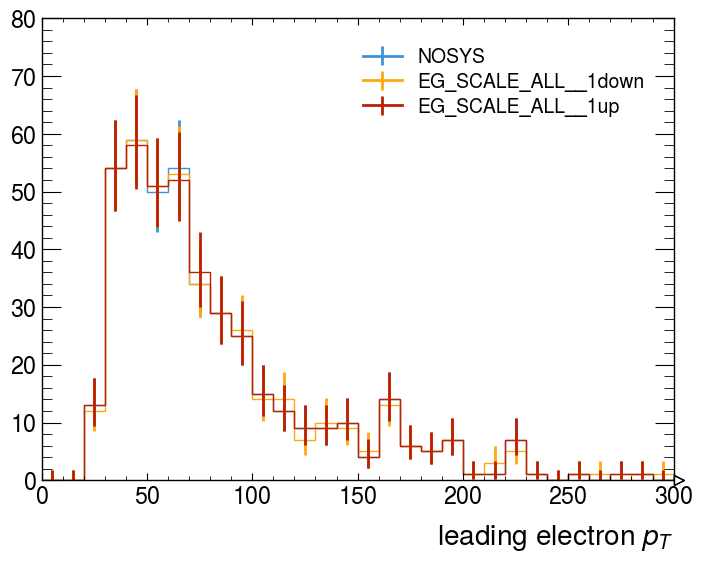

In [4]:
class TCPTSchema(NtupleSchema):
    # mcChannelNumber not defined for data
    event_ids = {"actualInteractionsPerCrossing", "averageInteractionsPerCrossing", "eventNumber", "mcChannelNumber", "runNumber"}
    mixins = {
        "globalTriggerEffSF": "Weight",  # events["NOSYS"].globalTriggerEffSF.emu
        "globalTriggerMatch": "Systematic",  # events["NOSYS"].globalTriggerMatch.emu
        **NtupleSchema.mixins
    }

events = NanoEventsFactory.from_root(
    {list(fileset[list(fileset.keys())[0]]["files"])[0]: "reco"},
    mode="virtual",
    schemaclass=TCPTSchema,
    entry_stop=1000,
    access_log=(access_log := []),
).events()

h = hist.new.Regular(30, 0, 300, label="leading electron $p_T$").StrCat([], name="variation", growth=True).Weight()

for variation in events.systematic_names:
    if variation != "NOSYS" and "EG_SCALE_ALL" not in variation:
        continue

    cut = events[variation]["pass"]["ejets"] == 1
    h.fill(events[variation][cut==1].el.pt[:, 0] / 1_000, variation=variation)

fig, ax = plt.subplots()
for variation in h.axes[1]:
    h[:, variation].plot(histtype="step", label=variation, ax=ax)
_ = ax.legend()

### Pre-processing

This step touches every file to extract metadata.

In [5]:
run = processor.Runner(
    executor = processor.DaskExecutor(client=client, treereduction=4),
    # executor = processor.IterativeExecutor(),  # to run locally
    schema=TCPTSchema,
    savemetrics=True,
    chunksize=200_000,
    skipbadfiles=True,
    align_clusters=False,
    # maxchunks=1  # for debugging only
)


def extract_sumw(f):
    """read initial sum of weights, custom function to be injected during pre-processing"""
    matching_histograms = f.keys(filter_name="CutBookkeeper*NOSYS")
    if len(matching_histograms):
        sumw = float(f[matching_histograms[0]].values()[1])
    else:
        sumw = 0  # for data
    return {"sumw": sumw}


with performance_report(filename="preprocess.html"):
    # custom pre-processing: like coffea, but with more metadata
    t0 = time.time()
    preprocess_output = utils.custom_preprocess(fileset, client=client, chunksize=run.chunksize, custom_func=extract_sumw)
    t1 = time.time()


# calculate dataset-aggregated sumw (without chunk duplication) and update preprocessing metadata accordingly
sumw_dict = collections.defaultdict(dict)
for chunk in preprocess_output:
    sumw_dict[chunk.dataset][chunk.filename] = chunk.usermeta["sumw"]

for chunk in preprocess_output:
    # for data all sumw entries are 0, set the total to 1 manually
    chunk.usermeta.update({"sumw_dataset": sum(sumw_dict[chunk.dataset].values()) or 1})


# visualize task stream
ts = client.get_task_stream(start=f"{math.ceil(time.time()-t0)}s")
_ = utils.plot_taskstream(ts)

print(f"generated list of {len(preprocess_output)} work items in {t1-t0:.1f} sec:\n{preprocess_output[:3]}")

# write to disk
with open("preprocess_output.json", "w") as f:
    json.dump(utils.preprocess_to_json(preprocess_output), f)

[########################################] | 100% Completed | 21min 48.1s

(9007,
 [WorkItem(dataset='mc23_13p6TeV.700794.Sh_2214_Ztautau_maxHTpTV2_CVetoBVeto.deriv.DAOD_PHYSLITE.e8514_s4369_r16083_p6697', filename='root://192.170.240.191:1094//root://xrootd.data.net2.mghpcc.org:1094//USATLAS/atlaslocalgroupdisk/rucio/user/alheld/81/f8/user.alheld.47045256._000013.output.root', treename='reco', entrystart=0, entrystop=680, fileuuid=b'\x9f\xee\x19x\xb2\x18\x11\xf0\xb8\xedq\n\x02\n\xbe\xef', usermeta={'lumi': 109376.0, 'weight_xs': 1973.0607342, 'dsid': '700794', 'campaign': 'mc23e'}),
  WorkItem(dataset='mc23_13p6TeV.700794.Sh_2214_Ztautau_maxHTpTV2_CVetoBVeto.deriv.DAOD_PHYSLITE.e8514_s4369_r16083_p6697', filename='root://192.170.240.194:1094//root://xrootd.data.net2.mghpcc.org:1094//USATLAS/atlaslocalgroupdisk/rucio/user/alheld/3a/c2/user.alheld.47045256._000012.output.root', treename='reco', entrystart=0, entrystop=11033, fileuuid=b'\x84\x0c6\x9a\xb2\x18\x11\xf0\x917\xa9\xe7\xb4\x9d\xbe\xef', usermeta={'lumi': 109376.0, 'weight_xs': 1973.0607342, 'dsid': '7

### Processing

This either uses `coffea`'s `Runner` interface or a custom `dask.bag` method for more metadata tracking.
Configure this via `USE_CUSTOM_PROCESSING`.
The custom approach is needed for instantaneous data rate calculation in this notebook.

Track XCache egress: [link](https://grafana.mwt2.org/d/EKefjM-Sz/af-network-200gbps-challenge?orgId=1&from=now-1h&to=now&viewPanel=panel-205&refresh=5s)

In [ ]:
# configure whether to use coffea Runner interface or custom dask.bag-based version
USE_CUSTOM_PROCESSING = True


class Analysis(processor.ProcessorABC):
    def __init__(self):
        self.h = hist.new.Regular(20, 0, 1_000, label="$m_{jj}$ [GeV]").\
            StrCat([], name="category", growth=True).\
            StrCat([], name="variation", growth=True).\
            Weight()

    def process(self, events):
        sumw = events.metadata["sumw_dataset"]
        for variation in events.systematic_names:
            if variation not in ["NOSYS"] + [name for name in events.systematic_names if "JET_JER_Effective" in name]:
                continue

            cut = events[variation]["pass"]["ejets"] == 1
            # TODO: remaining weights
            weight = (events[variation][cut==1].weight.mc if events.metadata["dsid"] != "data" else 1.0) * events.metadata["weight_xs"] * events.metadata["lumi"] / sumw
            mjj = (events[variation][cut==1].jet[:, 0] + events[variation][cut==1].jet[:, 1]).mass
            self.h.fill(mjj / 1_000, category=events.metadata["category"], variation=variation, weight=weight)

        return {"hist": self.h, "meta": {}}

    def postprocess(self, accumulator):
        pass


# load pre-processing information from disk
with open("preprocess_output.json") as f:
    preprocess_output = utils.json_to_preprocess(json.load(f))

client.run_on_scheduler(utils.start_tracking)  # track worker count on scheduler
t0 = time.time()  # track walltime

if USE_CUSTOM_PROCESSING:
    # configure here whether to preload branches
    columns_to_preload = json.load(pathlib.Path("columns_to_preload.json").open())["JET_JER_Effective"]  # or []

    with performance_report(filename="process_custom.html"):
        out, report = utils.custom_process(preprocess_output, processor_class=Analysis, schema=run.schema, client=client, preload=columns_to_preload)
    print(f"preloaded columns: {len(columns_to_preload)}, {columns_to_preload[:4]} {"etc." if len(columns_to_preload) > 4 else ""}")
    print(f"preloaded but unused columns: {len([c for c in columns_to_preload if c not in report["columns"]])}")
    print(f"used but not preloaded columns: {len([c for c in report["columns"] if c not in columns_to_preload])}")

    # shortened version of report, dropping extra columns and per-chunk information
    display(
        dict((k, v) for k, v in report.items() if k not in ["columns", "chunk_info"]) | 
        {"columns": report["columns"][0:10] + ["..."]} | 
        {"chunk_info": list(report["chunk_info"].items())[:2] + ["..."]}
    )

else:
    # coffea Runner-based processing
    with performance_report(filename="process.html"):
        out, report = run(preprocess_output, processor_instance=Analysis())

    # shortened version of report, dropping extra columns
    display(dict((k, v) for k, v in report.items() if k != "columns") | ({"columns": report["columns"][0:10] + ["..."]}))

t1 = time.time()
worker_count_dict = client.run_on_scheduler(utils.stop_tracking)  # stop tracking, read out data, get average
nworker_avg = utils.get_avg_num_workers(worker_count_dict)

print(f"histogram size: {out["hist"].view(True).nbytes / 1_000 / 1_000:.2f} MB\n")

[########################################] | 100% Completed | 33min 55.3s

{'bytesread': 183286387613,
 'columns': ['pass_ejets_EG_SCALE_ALL__1up',
  'el_e_NOSYS',
  'el_pt_NOSYS',
  'el_pt_EG_SCALE_ALL__1up',
  'el_isol_effSF_tight_NOSYS',
  'el_pt_EG_SCALE_ALL__1down',
  'el_isol_effSF_tight_EG_SCALE_ALL__1up',
  'pass_ejets_EG_SCALE_ALL__1down',
  'pass_ejets_NOSYS',
  'weight_mc_NOSYS',
  'el_isol_effSF_tight_EG_SCALE_ALL__1down'],
 'entries': 1087875546,
 'processtime': 12426.252845525742,
 'chunks': 9007}

In [7]:
print(f"walltime: {t1 - t0:.2f} sec ({(t1 - t0) / 60:.2f} min)")
print(f"average worker count: {nworker_avg:.1f}")
print(f"number of events processed: {report["entries"]:,}\n")

print(f"data read: {report["bytesread"] / 1000**3:.2f} GB in {report["chunks"]} chunks (average {report["bytesread"] / 1000**3 / report["chunks"]:.2f} GB per chunk)")
print(f"average total data rate: {report["bytesread"] / 1000**3 * 8 / (t1 - t0):.2f} Gbps")
print(f"fraction of input files read: {report["bytesread"] / 1000**3 / input_size_GB:.1%}")
print(f"number of branches read: {len(report["columns"])}\n")

print(f"worker-average event rate using \'processtime\': {report["entries"] / 1000 / report["processtime"]:.2f} kHz")
print(f"worker-average data rate using \'processtime\': {report["bytesread"] / 1000**3 * 8 / report["processtime"]:.2f} Gbps\n")

print(f"average event rate using walltime and time-averaged worker count: {report["entries"] / 1000 / (t1 - t0) / nworker_avg:.2f} kHz")
print(f"average data rate using walltime and time-averaged worker count: {report["bytesread"] / 1000**3 * 8 / (t1 - t0) / nworker_avg:.2f} Gbps\n")

print(f"fraction of time spent in processing: {report["processtime"] / ((t1 - t0) * nworker_avg):.1%}")
print(f"average process task length: {report["processtime"] / report["chunks"]:.1f} sec")

timestamps, datarates = utils.calculate_instantaneous_rates(t0, t1, report, num_samples=50)
_ = utils.plot_worker_count(worker_count_dict, timestamps, datarates)

# visualize task stream
ts = client.get_task_stream(start=f"{math.ceil(time.time()-t0)}s")
_ = utils.plot_taskstream(ts)

data read: 183.29 GB in 9007 chunks
core-average event rate using 'processtime': 87.55 kHz
core-average data rate using 'processtime': 0.12 Gbps
average event rate using walltime: 533.80 kHz
average data rate using walltime: 0.72 Gbps


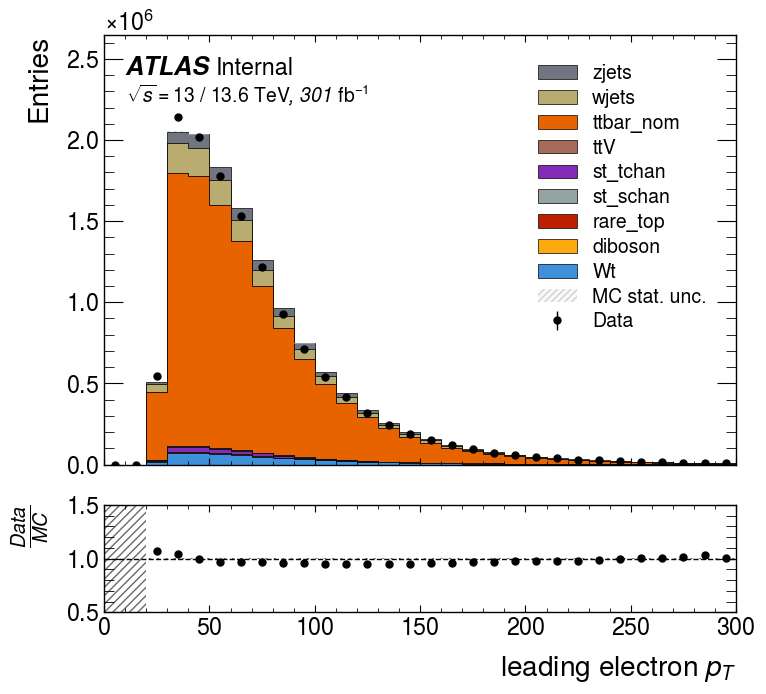

In [8]:
mc_stack = []
labels = []
for cat in sorted(out["hist"].axes[1]):
    if cat in ["data", "ttbar_H7", "ttbar_hdamp", "ttbar_pthard", "Wt_DS", "Wt_H7", "Wt_pthard"]:
        continue  # data drawn separately, skip MC modeling variations

    mc_stack.append(out["hist"][:, cat, "NOSYS"])
    labels.append(cat)

try:
    data_hist = out["hist"][:, "data", "NOSYS"]
except KeyError:
    print("falling back to plotting first entry of categorical axes as \"data\"")
    data_hist = out["hist"][:, 0, 0]

fig, ax1, ax2 = mplhep.comp.data_model(
    data_hist=data_hist,
    stacked_components=mc_stack,
    stacked_labels=labels,
    # https://scikit-hep.org/mplhep/gallery/model_with_stacked_and_unstacked_histograms_components/
    # unstacked_components=[],
    # unstacked_labels=[],
    xlabel=out["hist"].axes[0].label,
    ylabel="Entries",
)

mplhep.atlas.label("Internal", ax=ax1, data=True, lumi=f"{utils.integrated_luminosity("", total=True) / 1000:.0f}", com="13/ \\ 13.6 \\ TeV")
mplhep.mpl_magic(ax=ax1)
ax2.set_ylim([0.5, 1.5])

# compare to e.g. https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/HDBS-2020-11/fig_02a.png
fig.savefig("mjj.png")

In [9]:
# save to disk
import uhi.io.json

with gzip.open("hist.json.gz", "w") as f:
    f.write(json.dumps(out["hist"], default=uhi.io.json.default).encode("utf-8"))

with gzip.open("hist.json.gz") as f:
    h = hist.Hist(json.loads(f.read(), object_hook=uhi.io.json.object_hook))

In [29]:
h = hist.new.Regular(30, 0, 300, label="leading electron $p_T$").StrCat([], name="variation", growth=True).Weight()

for variation in events.systematic_names:
    if variation != "NOSYS" and "EG_SCALE_ALL" not in variation:
        continue
    h.fill(events[variation][cut==1].el.pt[:, 0] / 1_000, variation=variation)

fig, ax = plt.subplots()
for variation in h.axes[1]:
    h[:, variation].plot(histtype="step", label=variation, ax=ax)
_ = ax.legend()

ValueError: array does not have azimuthal coordinates (x/px, y/py or rho/pt, phi): pt, e